In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")


In [2]:


# Define the root directory
root_dir = Path("NEON_elev-groundwater-ALLCheck")

station_data = {}

# Gather all relevant folders 
for year in ["2019", "2020", "2021", "2022", "2023"]:
    for month in ["01","02","03", "04","05","06", "07", "08", "09", "10", "11", "12"]:
        month_folder = list(root_dir.glob(f"*{year}-{month}.basic.*"))
        if not month_folder:
            continue
        folder = month_folder[0]

        # Find all 30_min CSV files in the folder
        csv_files = sorted(folder.glob("*_30_min.*.csv"))

        for file in csv_files:
            # Extract station ID like 301, 302, etc.
            match = re.search(r"\.(30[1-5])\..*30_min", file.name)
            if not match:
                continue
            station_id = match.group(1)
            col_name = f"{station_id}_gw_elev"

            # Read CSV
            df = pd.read_csv(file, parse_dates=["startDateTime"])

            if "groundwaterElevMean" not in df.columns:
                print(f"Skipping {file.name} — 'groundwaterElevMean' column not found.")
                continue

            df["startDateTime"] = pd.to_datetime(df["startDateTime"], utc=True)
            df = df.set_index("startDateTime")

            # Append or initialize data for the station
            if col_name not in station_data:
                station_data[col_name] = df[["groundwaterElevMean"]]
            else:
                station_data[col_name] = pd.concat([station_data[col_name], df[["groundwaterElevMean"]]])

    # Now resample each station's time series to daily average
    daily_data = {}
    for col_name, df in station_data.items():
        daily_avg = df["groundwaterElevMean"].resample("D").mean()
        daily_data[col_name] = daily_avg

    # Combine into single DataFrame
    combined_df = pd.DataFrame(daily_data)

    # Reset index and rename for final format
    combined_df = combined_df.reset_index().rename(columns={"startDateTime": "datetime"})

    # Preview
    combined_df.head()

    # Save the combined DataFrame to a CSV file
    output_file = f"NEON_groundwater_elevations_ALL{year}.csv"
    combined_df.to_csv(output_file, index=False, float_format="%.4f")


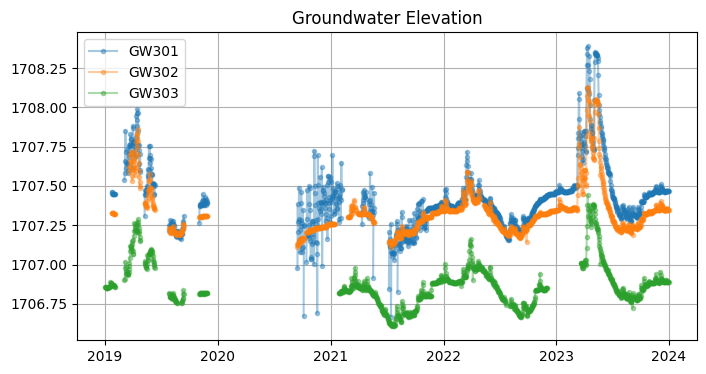

In [3]:
plt.figure(figsize=(8 ,4))
plt.title("Groundwater Elevation")

plt.plot(combined_df["datetime"], combined_df["301_gw_elev"], '.-', alpha=0.4,label="GW301")
plt.plot(combined_df["datetime"], combined_df["302_gw_elev"], '.-', alpha=0.4,label="GW302")
plt.plot(combined_df["datetime"], combined_df["303_gw_elev"], '.-', alpha=0.4,label="GW303")
# plt.plot(combined_df["datetime"], combined_df["304_gw_elev"], '.-', alpha=0.4,label="304")
# plt.plot(combined_df["datetime"], combined_df["305_gw_elev"], '.-', alpha=0.4,label="305")
plt.legend()
plt.grid(True)

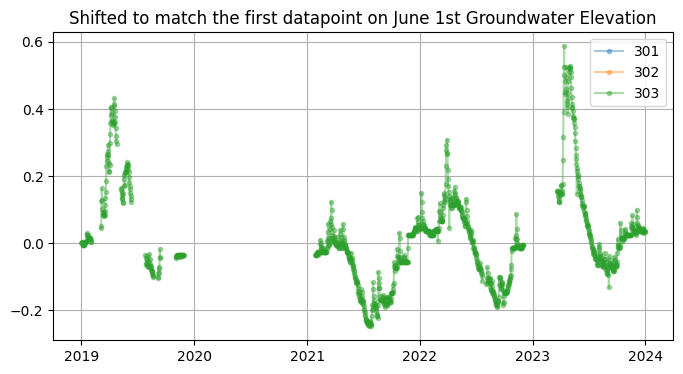

In [4]:
plt.figure(figsize=(8 ,4))
plt.title("Shifted to match the first datapoint on June 1st Groundwater Elevation")
plt.plot(combined_df["datetime"], combined_df["301_gw_elev"]-combined_df["301_gw_elev"][0], '.-', label="301", alpha=0.4)
plt.plot(combined_df["datetime"], combined_df["302_gw_elev"]-combined_df["302_gw_elev"][0], '.-', label="302", alpha=0.4)
plt.plot(combined_df["datetime"], combined_df["303_gw_elev"]-combined_df["303_gw_elev"][0], '.-', label="303", alpha=0.4)
# plt.plot(combined_df["datetime"], combined_df["304_gw_elev"]-combined_df["304_gw_elev"][0], '.-', label="304")
# plt.plot(combined_df["datetime"], combined_df["305_gw_elev"]-combined_df["305_gw_elev"][0], '.-', label="305")
plt.legend()
plt.grid(True)

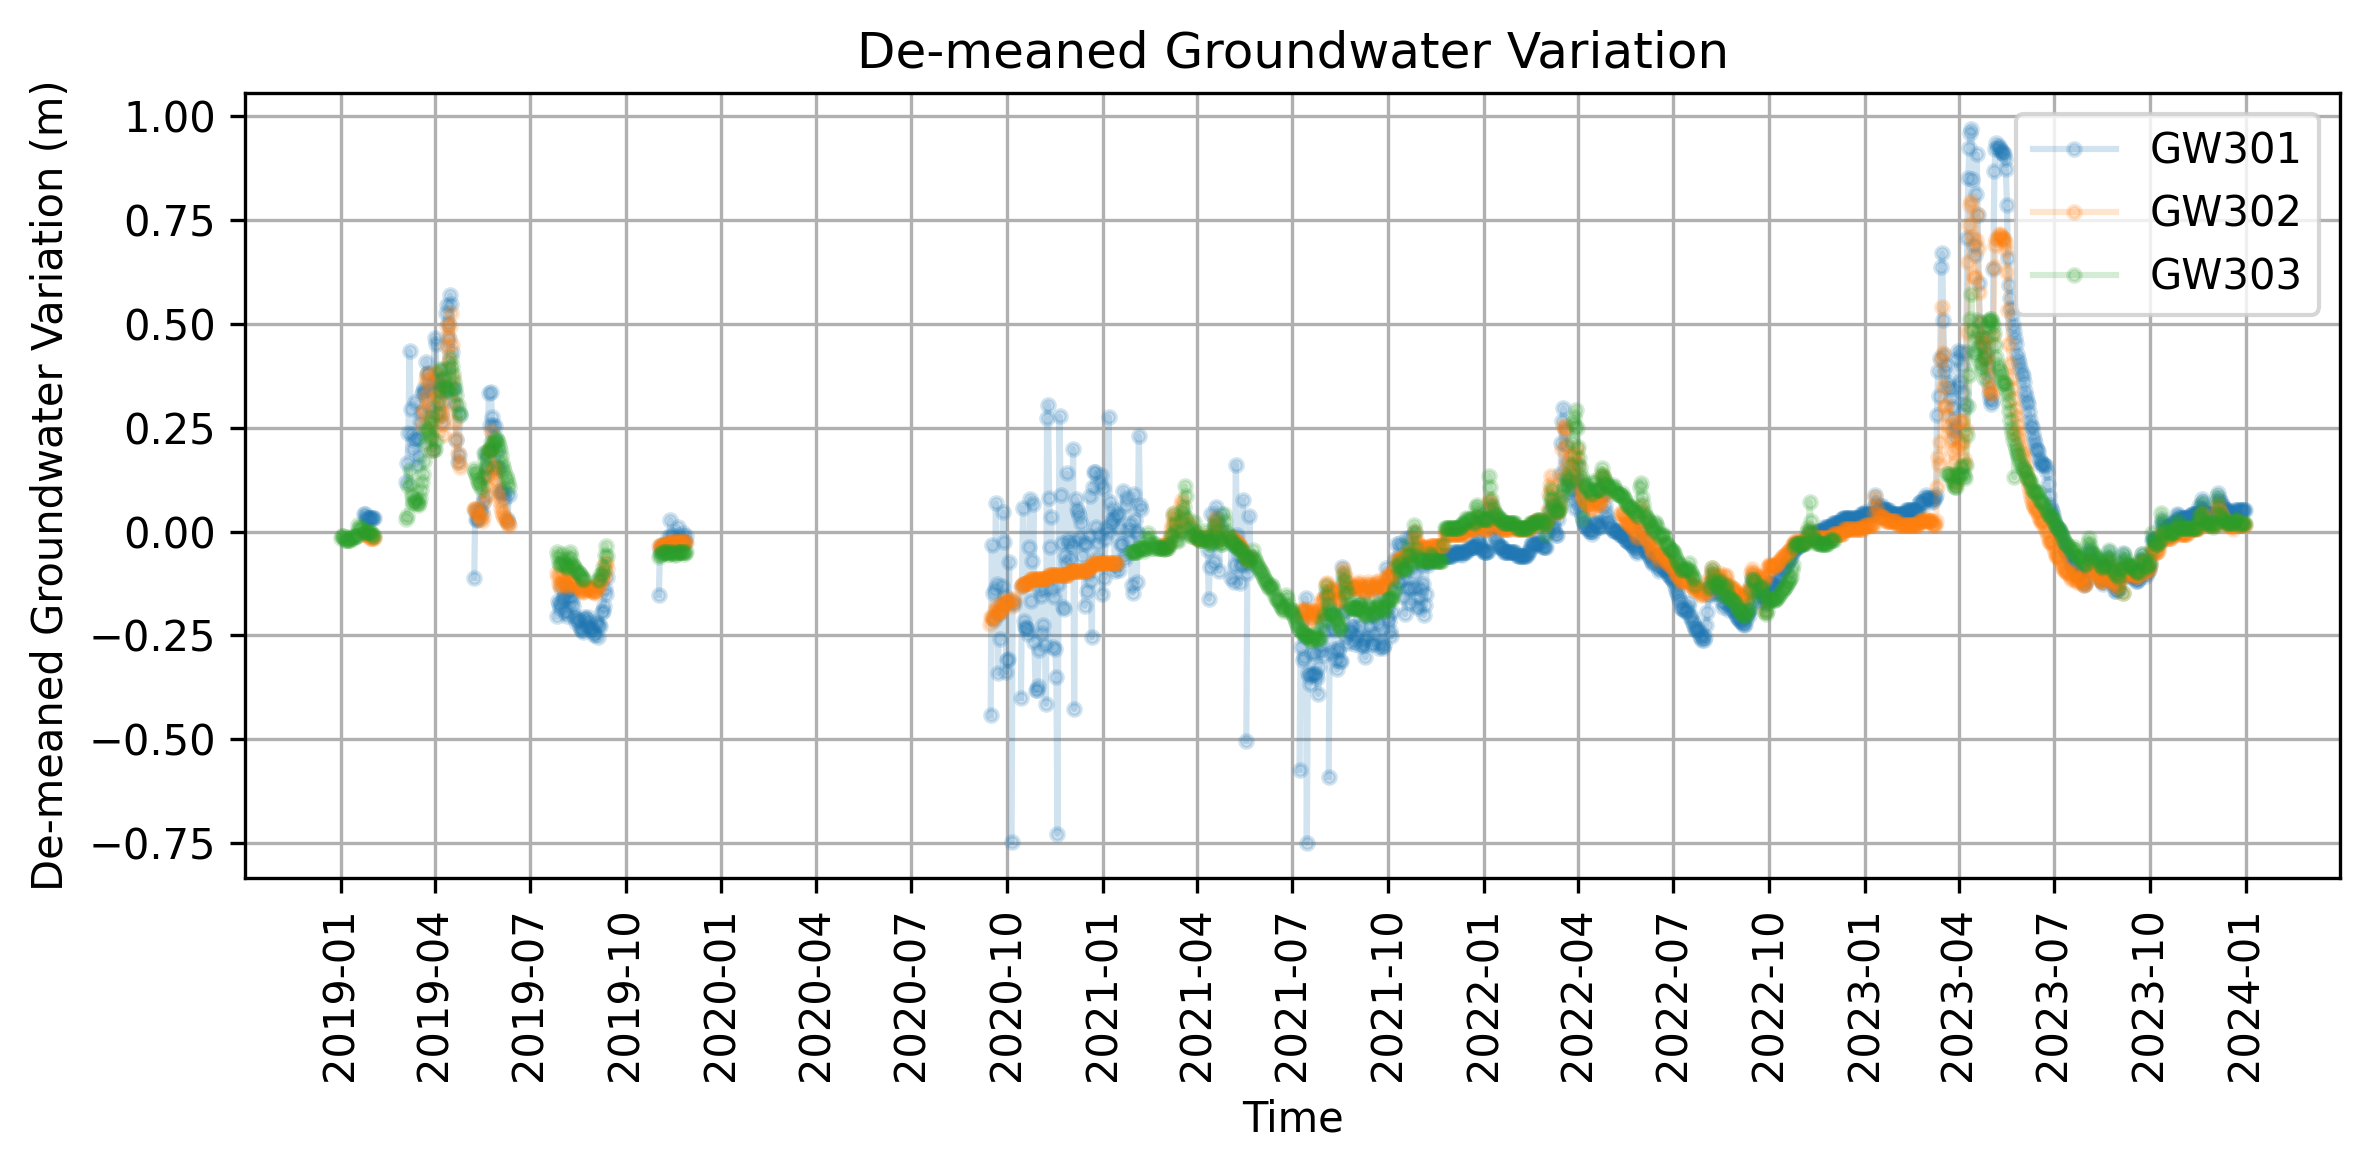

In [5]:
plt.figure(figsize=(8, 4),dpi=300)
plt.title("De-meaned Groundwater Variation")
plt.plot(combined_df["datetime"], combined_df["301_gw_elev"] - combined_df["301_gw_elev"].mean(), '.-', alpha=0.2, label="GW301")
plt.plot(combined_df["datetime"], combined_df["302_gw_elev"] - combined_df["302_gw_elev"].mean(), '.-', alpha=0.2, label="GW302")
plt.plot(combined_df["datetime"], combined_df["303_gw_elev"] - combined_df["303_gw_elev"].mean(), '.-', alpha=0.2, label="GW303")
# plt.plot(combined_df["datetime"], combined_df["304_gw_elev"] - combined_df["304_gw_elev"].mean(), '.-', alpha=0.4, label="304")
# plt.plot(combined_df["datetime"], combined_df["305_gw_elev"] - combined_df["305_gw_elev"].mean(), '.-', alpha=0.4, label="305")
plt.xlabel("Time")
plt.ylabel("De-meaned Groundwater Variation (m)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

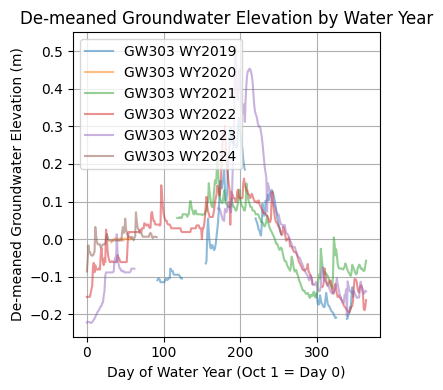

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Ensure datetime is timezone-naive
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"]).dt.tz_localize(None)

# Define water year and day-of-water-year
def get_water_year(date):
    return date.year + 1 if date.month >= 10 else date.year

def get_day_of_water_year(date):
    start = pd.Timestamp(get_water_year(date) - 1, 10, 1)
    return (date - start).days

combined_df["water_year"] = combined_df["datetime"].apply(get_water_year)
combined_df["day_of_wy"] = combined_df["datetime"].apply(get_day_of_water_year)


# Step 2: Plot each year’s data
plt.figure(figsize=(4, 4), dpi=100)
plt.title("De-meaned Groundwater Elevation by Water Year")

for wy in sorted(combined_df["water_year"].unique()):
    subset = combined_df[combined_df["water_year"] == wy]
    plt.plot(subset["day_of_wy"], 
             subset["303_gw_elev"] - subset["303_gw_elev"].mean(), 
             label=f"GW303 WY{wy}", alpha=0.5)

# Optional: repeat for other wells (GW302, GW303)
# You could also stack plots or use subplots if needed

# Step 3: Customize x-axis and labels
plt.xlabel("Day of Water Year (Oct 1 = Day 0)")
plt.ylabel("De-meaned Groundwater Elevation (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


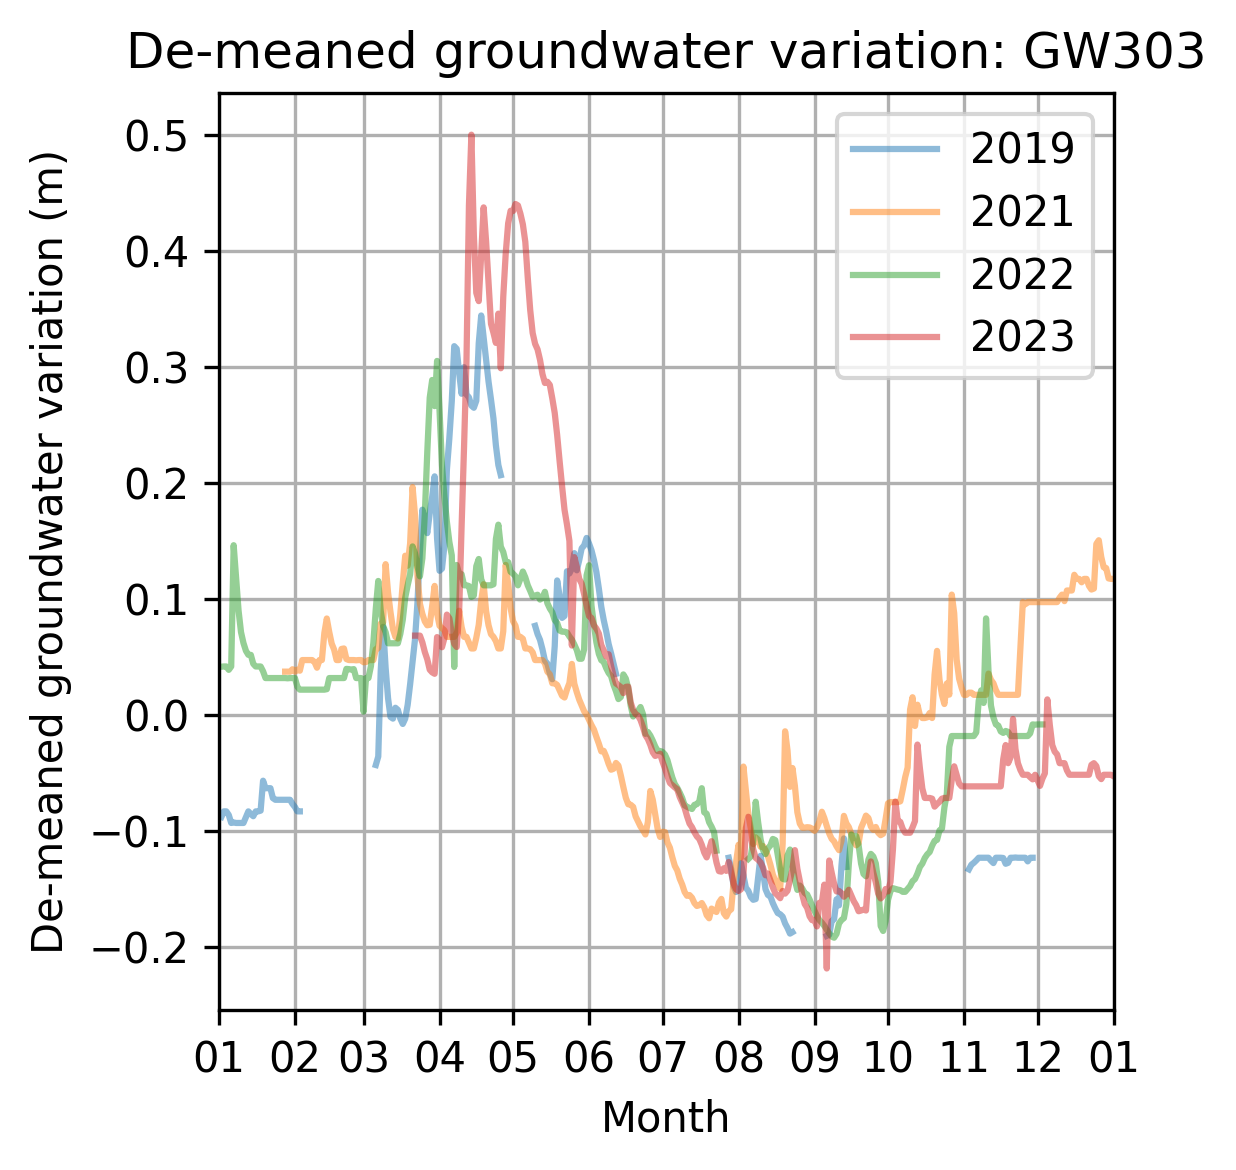

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is timezone-naive and in datetime format
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"]).dt.tz_localize(None)

# Add calendar year and day-of-year columns
combined_df["year"] = combined_df["datetime"].dt.year
combined_df["day_of_year"] = combined_df["datetime"].dt.dayofyear

# Plot
plt.figure(figsize=(4,4), dpi=300)
plt.title("De-meaned groundwater variation: GW303")

for year in sorted(combined_df["year"].unique()):
    subset = combined_df[combined_df["year"] == year]

    # Skip if there's no valid data
    if subset["303_gw_elev"].dropna().empty:
        continue
    subset = combined_df[combined_df["year"] == year]
    plt.plot(subset["day_of_year"], 
             subset["303_gw_elev"] - subset["303_gw_elev"].mean(), 
             label=f"{year}", alpha=0.5)
            #  label=f"GW303 in {year}", alpha=0.5)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
plt.xticks(rotation=0)
plt.xlim(0, 365)  # Set x-axis limits to cover the full year

plt.xlabel("Month")
plt.ylabel("De-meaned groundwater variation (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


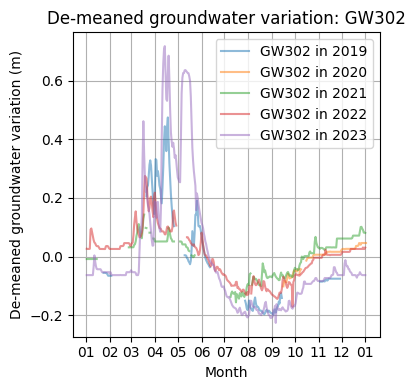

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is timezone-naive and in datetime format
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"]).dt.tz_localize(None)

# Add calendar year and day-of-year columns
combined_df["year"] = combined_df["datetime"].dt.year
combined_df["day_of_year"] = combined_df["datetime"].dt.dayofyear

# Plot
plt.figure(figsize=(4,4), dpi=100)
plt.title("De-meaned groundwater variation: GW302")

for year in sorted(combined_df["year"].unique()):
    subset = combined_df[combined_df["year"] == year]
    plt.plot(subset["day_of_year"], 
             subset["302_gw_elev"] - subset["302_gw_elev"].mean(), 
             label=f"GW302 in {year}", alpha=0.5)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
plt.xticks(rotation=0)

plt.xlabel("Month")
plt.ylabel("De-meaned groundwater variation (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


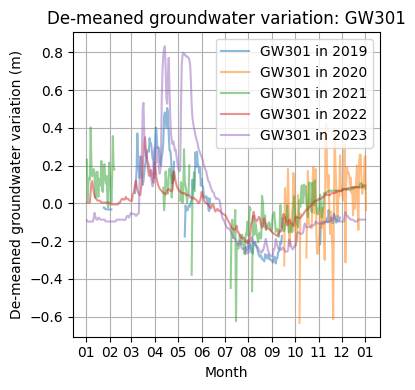

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime is timezone-naive and in datetime format
combined_df["datetime"] = pd.to_datetime(combined_df["datetime"]).dt.tz_localize(None)

# Add calendar year and day-of-year columns
combined_df["year"] = combined_df["datetime"].dt.year
combined_df["day_of_year"] = combined_df["datetime"].dt.dayofyear

# Plot
plt.figure(figsize=(4,4), dpi=100)
plt.title("De-meaned groundwater variation: GW301")

for year in sorted(combined_df["year"].unique()):
    subset = combined_df[combined_df["year"] == year]
    plt.plot(subset["day_of_year"], 
             subset["301_gw_elev"] - subset["301_gw_elev"].mean(), 
             label=f"GW301 in {year}", alpha=0.5)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
plt.xticks(rotation=0)

plt.xlabel("Month")
plt.ylabel("De-meaned groundwater variation (m)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
